In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def calc_price(phi1, phi2, cost, wtp,mc):
    """compute each insurer's price (assumes interior solution)"""
    mc1,mc2 = mc
    p1 = (2*(phi1+mc1)+phi2+mc2)/3. + cost
    p2 = (2*(phi2+mc2)+phi1+mc1)/3. + cost
    return p1, p2
  
    
def calc_s(phi1, phi2, cost, wtp,mc):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    p1, p2 = calc_price(phi1, phi2, cost, wtp,mc)
    t_hat = .5 + (p2 - p1)/(2.*cost)
    return t_hat


def calc_profits(phi1,phi2,cost, wtp, mc):
    mc1,mc2 = mc
    s= calc_s(phi1, phi2, cost, wtp,mc)
    p1,p2 = calc_price(phi1, phi2, cost, wtp,mc)
    profits1, profits2 = s*(p1-phi1-mc1), (1-s)*(p2-phi2-mc2)
    hosp_profit = s*(phi1) +  (1-s)*(phi2)
    return hosp_profit, profits1, profits2

    
def outside_simlt(phi1, phi2, cost, wtp,  mc, active=False):
    """outside option in simult case
    assuming listprice high enough"""
    
    mc1,mc2 = mc
    s_hat = calc_s(phi1, phi2, cost, wtp,mc) # s_hat with no recapture
    p1,p2 = calc_price(phi1, phi2, cost, wtp,mc)
    s_hat  = np.clip((cost + p2 - wtp)/cost,0,1) #s_hat with recapture

    if active:
        return (wtp-cost)/2 - mc2 #outside cost is other insurer?
    return (1-s_hat)*(phi2 -mc2)

#arbitrary outside option...
def nash_in_nash(phi1, phi2, cost, wtp, mc, beta=.5,active=False):
    hosp_profit, profits1, profits2 = calc_profits(phi1, phi2,  cost,  wtp, mc)
    obj = -1*(np.log(max(hosp_profit-outside_simlt(phi1, phi2,cost, wtp , mc, active=active),1e-4))*(1-beta) 
              + np.log(profits1)*beta)
    return obj


COST = 5
WTP = 25
MC = np.array([0,0])

print(nash_in_nash(3*COST,3*COST, COST, WTP, MC))

4.147024820051014


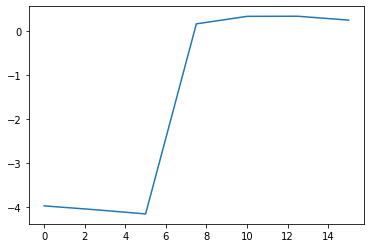

In [3]:
COST = 5
WTP = 25
MC = np.array([0,0])

plt.plot([i for i in np.linspace(0,3*COST,num=7)], 
         [-1*nash_in_nash(i, 4, COST,WTP,MC) for i in np.linspace(1,2*COST,num=7)])

In [5]:
def bargain_helper(phi1, phi2, cost, wtp, mc, beta=.5,active=False):
    """solve each firm 1s optimization holding phi 2 fixed"""
    result = minimize(nash_in_nash, phi1, args=(phi2,cost, wtp, mc, beta, active),
                      method='Nelder-Mead', options={'disp': False})
    return result.x

COST = 5
WTP  = 25
MC = np.array([0,0])

print(bargain_helper(15,15, COST,WTP,MC,beta=.5,active=True))

[14.04830933]


In [13]:
def simult_bargain(phi1, phi2, cost, wtp, mc, betas=[.5,.5],active=False):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables, check on this...
    diff =  np.maximum(phi1,phi2)
    phi10,phi20 = 0,0
    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        phi1 = bargain_helper(phi1, phi2, cost, wtp, mc, beta=betas[0] ,active=active)
        phi2 = bargain_helper(phi2, phi1, cost, wtp, mc[::-1], beta=betas[1],active=active)
        
        #update loop variables
        diff = np.abs(np.maximum(phi1 - phi10,phi2-phi20))[0]
        phi10,phi20 = phi1,phi2
        maxiter = maxiter-1
        
    return phi1, phi2

COST = 5
WTP  = 25
MC = np.array([1.5,0])
print(simult_bargain(15,15,COST,WTP,MC,active=True))
#print(simult_bargain(15,15,COST,WTP,MC,active=True))

(array([14.53753043]), array([13.03754291]))


In [15]:
COST = 5
WTP  = 25

print("cost1","phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,2,5):
    mc_i = np.array([i, 0])
    phi1,phi2 = simult_bargain(22,22,COST,WTP,mc_i,active=True)
    hosp_profit, profits1, profits2= calc_profits(phi1[0],phi2[0],COST, WTP, mc_i )
    print(i, round(phi1[0],3), round(phi2[0],3), round(hosp_profit,3), round(profits1,3), round(profits2,3))

cost1 phi 1 phi 2 hosp profit profit 1 profit 2
0.0 13.75 13.75 13.75 2.5 2.5
0.5 14.004 13.504 13.504 2.336 2.669
1.0 14.267 13.267 13.267 2.178 2.844
1.5 14.538 13.038 13.038 2.025 3.025
2.0 14.817 12.817 12.817 1.878 3.211


In [10]:
#generate a bunch of runs with passive and compute costs

def compute_cov(active,nobs=1000):
    mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    phis = []
    for i in range(nobs):
        phi = simult_bargain(11.25,11.25,COST,WTP,mcs[:,i],active=active) 
        phis.append(np.array(phi).flatten())

    phis = np.array(phis)
    return np.cov(phis,rowvar=False)

print(compute_cov(active=True))
print(compute_cov(active=False))

[[ 0.16808356 -0.16753985]
 [-0.16753985  0.16769422]]
[[ 0.18813803 -0.15855749]
 [-0.15855749  0.17950301]]


In [11]:
#just make sure it works for stuff i know is right

def compute_solution(active,nobs=20):
    #mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    phis = []
    vs = np.random.uniform(low=25,high=25.5,size=(nobs))
    lambdas = np.random.uniform(low=5,high=6,size=(nobs))
    x = np.concatenate(([vs],[lambdas])) #,mcs
    for i in range(nobs):
        phi = simult_bargain(11.25,11.25,lambdas[i],vs[i],np.array([0,0]),active=active) 
        phis.append(np.array(phi).flatten())
    phis = np.array(phis)
    xx = x.dot(x.transpose())
    xy1 = x.dot(phis[:,0])
    xy2 = x.dot(phis[:,1])
    return np.linalg.inv(xx).dot(xy1),np.linalg.inv(xx).dot(xy2)
    
print(compute_solution(active=True,nobs=10))
print(compute_solution(active=False,nobs=10))

(array([0.49999268, 0.25003131]), array([0.50000266, 0.24998751]))
(array([0.00907646, 2.7942333 ]), array([-1.14362843e+58,  4.52531544e+58]))


In [12]:
def compute_solution(active,nobs=20):
    
    #set up x variables to solve the model
    phis = []
    vs = np.random.uniform(low=25,high=26,size=(nobs))
    lambdas = np.random.uniform(low=5,high=6,size=(nobs))
    mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    x = np.concatenate(([vs],[lambdas],mcs))
    
    #generate a few solutions...
    for i in range(nobs):
        phi = simult_bargain(11.25,11.25,lambdas[i],vs[i],mcs[:,i],active=active) 
        phis.append(np.array(phi).flatten())
        
    #do regression stuff to solve
    phis = np.array(phis)
    xx = x.dot(x.transpose())
    xy1 = x.dot(phis[:,0])
    xy2 = x.dot(phis[:,1])
    return np.linalg.inv(xx).dot(xy1),np.linalg.inv(xx).dot(xy2)

#coeffs are v, lambda, c1, c2
print(compute_solution(active=True,nobs=10))
print(compute_solution(active=False,nobs=10))
    

(array([ 0.50420528,  0.23358377,  0.49540777, -0.5025153 ]), array([ 0.50421573,  0.23353855, -0.5045729 ,  0.49746544]))
(array([ 0.47961544,  0.59418928,  0.63774833, -0.71094437]), array([-1.92678570e+57,  6.25970483e+56,  4.50923431e+56, -1.56943212e+56]))
